# Imports

In [1]:
import os
import pickle
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime
from pathlib import Path

# Data loading

In [2]:
# Load the pickle file
train_data_path = Path('data/train_data.pkl')
with open(train_data_path, 'rb') as f:
    data = pickle.load(f)

images = data['images']
labels = data['labels']

# Data visualization

In [3]:
images.shape, labels.shape

((1080, 28, 28, 3), (1080, 1))

In [4]:
image_ex = images[0]
label_ex = labels[0]
image_ex.shape, label_ex.shape

((28, 28, 3), (1,))

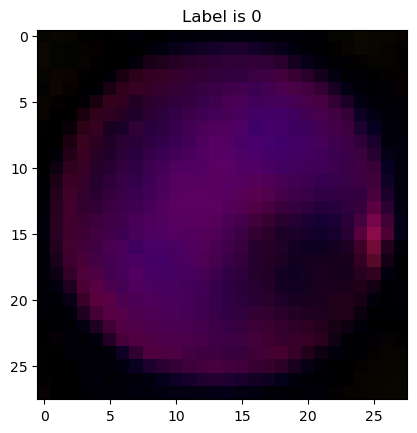

In [5]:
# Visualize first image
plt.title(f'Label is {label_ex.squeeze()}')
plt.imshow(image_ex)
plt.show()

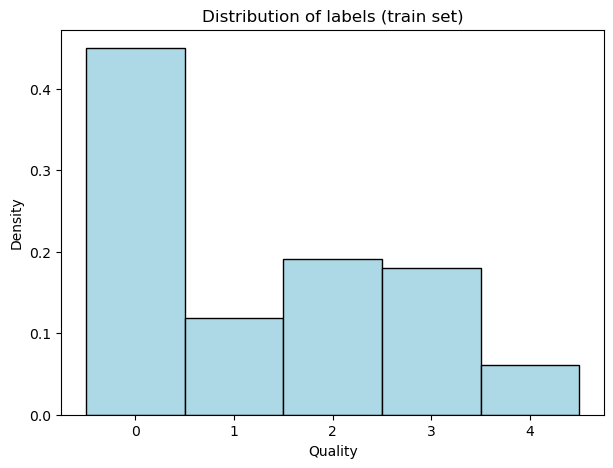

In [6]:
# Metrics
mean = np.mean(labels)
std = np.std(labels)
min_val = np.min(labels)
max_val = np.max(labels)

# Bin centering
bins = np.arange(min_val - 0.5, max_val + 1.5, 1) 

# Plot specifications
plt.figure(figsize=(7, 5))
plt.hist(labels, bins=bins, color='lightblue', edgecolor='black', density=True)
plt.title('Distribution of labels (train set)')
plt.xlabel('Quality')
plt.ylabel('Density')
plt.show()

# Kernel and One-VS-Rest SVM

In [7]:
def rbf_kernel_matrix(X1, X2, gamma=0.01):
    """
    Compute RBF kernel matrix between X1 and X2.
    K(x1, x2) = exp(-gamma * ||x1 - x2||^2)
    """
    # Using the identity: ||x1 - x2||^2 = ||x1||^2 + ||x2||^2 - 2 * x1 · x2
    X1_norm = (X1 ** 2).sum(axis=1).reshape(-1, 1)
    X2_norm = (X2 ** 2).sum(axis=1).reshape(1, -1)  # Shape (1, n2) for broadcasting
    dists = X1_norm + X2_norm - 2 * (X1 @ X2.T)
    
    # Numerical stability: clip negative values (can occur due to floating point errors)
    dists = np.maximum(dists, 0)
    
    # Clip large distances to prevent underflow in exp
    # exp(-gamma * d) where d > 700/gamma becomes essentially 0
    max_dist = 700.0 / gamma if gamma > 0 else np.inf
    dists = np.minimum(dists, max_dist)
    
    return np.exp(-gamma * dists)

In [8]:
class SVM:
    def __init__(self, n_features, reg):
        # Initialize weights with small random values (better than zeros)
        self.w = np.random.randn(n_features) * 0.01
        self.b = 0.0  # Bias term
        self.reg = reg
    
    def decision_function(self, X):
        """Raw prediction scores (before sign)"""
        return X @ self.w + self.b
    
    def predict(self, X):
        """For compatibility - returns raw scores for OvR"""
        return self.decision_function(X)

    def gradient(self, X, y):
        """Compute gradient of hinge loss + L2 regularization"""
        n_samples = X.shape[0]
        margins = y * self.decision_function(X)
        
        # Samples where margin < 1 contribute to gradient
        active = (margins < 1).astype(float)
        
        # Gradient w.r.t weights
        grad_w = -((y * active)[:, np.newaxis] * X).sum(axis=0) / n_samples + self.reg * self.w
        
        # Gradient w.r.t bias (no regularization on bias)
        grad_b = -(y * active).sum() / n_samples
        
        return grad_w, grad_b

    def train(self, X, y, stepsize, n_steps, decay=0.99, verbose=True):
        """
        Train with gradient descent and learning rate decay.
        
        Args:
            decay: Learning rate multiplier applied every 100 steps
        """
        losses = []
        errors = []
        lr = stepsize
        
        for step in range(n_steps):
            grad_w, grad_b = self.gradient(X, y)
            self.w -= lr * grad_w
            self.b -= lr * grad_b
            
            # Learning rate decay
            if (step + 1) % 100 == 0:
                lr *= decay

            # Monitoring (every 100 steps to save time)
            if step % 100 == 0 or step == n_steps - 1:
                losses.append(self.loss(X, y))
                errors.append(self.error_rate(X, y))

        if verbose:
            print(f"  -> Train error: {errors[-1] * 100:.2f}%, Loss: {losses[-1]:.4f}")
        
        return losses, errors

    def loss(self, X, y):
        """Hinge loss with L2 regularization"""
        margins = y * self.decision_function(X)
        hinge = np.maximum(0, 1 - margins)
        return np.mean(hinge) + (self.reg / 2) * np.sum(self.w ** 2)
    
    def error_rate(self, X, y):
        """Classification error rate"""
        predictions = np.sign(self.decision_function(X))
        return np.mean(predictions != np.sign(y))

In [9]:
class MulticlassSVM:
    def __init__(self, reg=0.1):
        self.reg = reg
        self.classifiers = []  # List of (class_label, svm) tuples
        self.classes_ = None
    
    def train(self, X, y, stepsize, n_steps, decay=0.99):
        """
        Train One-vs-Rest SVMs for each class.
        """
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_features = X.shape[1]
        
        print(f"Training {n_classes} binary classifiers...")
        print("-" * 40)
        
        for cls in self.classes_:
            print(f"Class {cls}:", end=" ")
            
            # Binary labels: +1 for this class, -1 for others
            binary_labels = np.where(y == cls, 1, -1).flatten()
            
            # Train binary SVM
            svm = SVM(n_features, self.reg)
            svm.train(X, binary_labels, stepsize, n_steps, decay, verbose=True)
            self.classifiers.append((cls, svm))
        
        print("-" * 40)
        print("Training complete!")
    
    def decision_function(self, X):
        """Get confidence scores for each class"""
        n_samples = X.shape[0]
        n_classes = len(self.classifiers)
        scores = np.zeros((n_samples, n_classes))
        
        for i, (_, svm) in enumerate(self.classifiers):
            scores[:, i] = svm.decision_function(X)
        
        return scores
    
    def predict(self, X):
        """Predict class with highest confidence score"""
        scores = self.decision_function(X)
        class_indices = np.argmax(scores, axis=1)
        return np.array([self.classes_[i] for i in class_indices])
    
    def error_rate(self, X, y):
        """Multiclass classification error rate"""
        predictions = self.predict(X)
        return np.mean(predictions != y.flatten())
    
    def accuracy(self, X, y):
        """Convenience method: return accuracy instead of error"""
        return 1.0 - self.error_rate(X, y)

# Training and validation

In [10]:
flatten_images = np.array([img.reshape(-1) for img in images])
flatten_images.shape

(1080, 2352)

In [11]:
normalized_images = flatten_images / 255.0

In [12]:
kernel = rbf_kernel_matrix(normalized_images, normalized_images, gamma=0.1)
kernel.shape

(1080, 1080)

In [13]:
N = labels.shape[0]
ratio = 0.8
train_size = int(ratio * N)
val_size = N - train_size

# Shuffle indices for random train/val split (important if data is ordered!)
np.random.seed(42)  # For reproducibility
indices = np.random.permutation(N)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

print(f"Train samples: {train_size}")
print(f"Val samples: {val_size}")

# Use shuffled indices for kernel submatrices
kernel_train = kernel[np.ix_(train_indices, train_indices)]
kernel_val = kernel[np.ix_(val_indices, train_indices)]

labels_train = labels[train_indices].flatten()
labels_val = labels[val_indices].flatten()

print(f"\nKernel train shape: {kernel_train.shape}")
print(f"Kernel val shape: {kernel_val.shape}")
print(f"Labels train shape: {labels_train.shape}")
print(f"Labels val shape: {labels_val.shape}")
print(f"\nClass distribution in train: {np.unique(labels_train, return_counts=True)}")
print(f"Class distribution in val: {np.unique(labels_val, return_counts=True)}")

Train samples: 864
Val samples: 216

Kernel train shape: (864, 864)
Kernel val shape: (216, 864)
Labels train shape: (864,)
Labels val shape: (216,)

Class distribution in train: (array([0, 1, 2, 3, 4], dtype=uint8), array([396,  97, 153, 160,  58], dtype=int64))
Class distribution in val: (array([0, 1, 2, 3, 4], dtype=uint8), array([90, 31, 53, 34,  8], dtype=int64))


In [14]:
# Train multiclass SVM
multi_svm = MulticlassSVM(reg=0.01)
multi_svm.train(kernel_train, labels_train, stepsize=0.1, n_steps=1000, decay=0.995)

# Evaluate
train_acc = multi_svm.accuracy(kernel_train, labels_train)
val_acc = multi_svm.accuracy(kernel_val, labels_val)

print(f"\n{'=' * 50}")
print(f"Train accuracy: {train_acc * 100:.2f}%")
print(f"Val accuracy: {val_acc * 100:.2f}%")
print(f"Overfitting gap: {(train_acc - val_acc) * 100:.2f}%")
print('=' * 50)

Training 5 binary classifiers...
----------------------------------------
Class 0:   -> Train error: 22.11%, Loss: 0.5375
Class 1:   -> Train error: 22.11%, Loss: 0.5375
Class 1:   -> Train error: 11.23%, Loss: 0.2367
Class 2:   -> Train error: 11.23%, Loss: 0.2367
Class 2:   -> Train error: 17.71%, Loss: 0.4372
Class 3:   -> Train error: 17.71%, Loss: 0.4372
Class 3:   -> Train error: 18.52%, Loss: 0.3752
Class 4:   -> Train error: 18.52%, Loss: 0.3752
Class 4:   -> Train error: 6.71%, Loss: 0.1639
----------------------------------------
Training complete!

Train accuracy: 54.51%
Val accuracy: 42.13%
Overfitting gap: 12.38%
  -> Train error: 6.71%, Loss: 0.1639
----------------------------------------
Training complete!

Train accuracy: 54.51%
Val accuracy: 42.13%
Overfitting gap: 12.38%


In [15]:
multi_svm.predict(kernel_val)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 3, 3, 0, 0, 0,
       1, 0, 0, 0, 3, 0, 3, 0, 1, 3, 1, 0, 0, 0, 3, 3, 0, 0, 1, 3, 0, 0,
       0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 3, 0, 3, 0, 0, 1, 0, 0, 3, 3,
       0, 0, 0, 3, 0, 0, 0, 0, 1, 3, 3, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3,
       3, 0, 1, 0, 0, 1, 0, 0, 3, 0, 0, 1, 1, 0, 0, 0, 0, 0, 3, 3, 0, 3,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 3, 1, 0, 1, 1, 1, 0, 3, 0, 3, 0, 3, 0,
       3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3,
       3, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 0, 0], dtype=uint8)

# Test on unseen data

In [16]:
# Load the pickle file
test_data_path = pathlib.Path('data/test_data.pkl')
with open(test_data_path, 'rb') as f:
    data = pickle.load(f)

images = data['images']

In [17]:
test_data = np.array([img.reshape(-1) for img in images]) / 255.0

In [18]:
test_kernel = rbf_kernel_matrix(test_data, normalized_images, gamma=0.1)

In [19]:
# Train on full dataset for final predictions
print("Training final model on full dataset...")
full_kernel = rbf_kernel_matrix(normalized_images, normalized_images, gamma=0.1)

multi_svm_final = MulticlassSVM(reg=0.01)
multi_svm_final.train(full_kernel, labels.flatten(), stepsize=0.1, n_steps=1000, decay=0.995)

# Compute test kernel against all training samples
test_kernel_final = rbf_kernel_matrix(test_data, normalized_images, gamma=0.1)
test_predictions = multi_svm_final.predict(test_kernel_final)

print(f"\nPredictions shape: {test_predictions.shape}")
print(f"Unique predicted classes: {np.unique(test_predictions)}")

Training final model on full dataset...
Training 5 binary classifiers...
----------------------------------------
Class 0:   -> Train error: 22.22%, Loss: 0.5560
Class 1:   -> Train error: 22.22%, Loss: 0.5560
Class 1:   -> Train error: 11.85%, Loss: 0.2758
Class 2:   -> Train error: 11.85%, Loss: 0.2758
Class 2:   -> Train error: 19.07%, Loss: 0.4303
Class 3:   -> Train error: 19.07%, Loss: 0.4303
Class 3:   -> Train error: 17.96%, Loss: 0.4151
Class 4:   -> Train error: 17.96%, Loss: 0.4151
Class 4:   -> Train error: 6.11%, Loss: 0.1262
----------------------------------------
Training complete!

Predictions shape: (400,)
Unique predicted classes: [0 2 4]
  -> Train error: 6.11%, Loss: 0.1262
----------------------------------------
Training complete!

Predictions shape: (400,)
Unique predicted classes: [0 2 4]


In [20]:
test_predictions

array([0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0,
       2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2,
       0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2,
       2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0,
       4, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0,
       0, 0, 4, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2,
       0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2,
       0, 2, 2, 0, 2, 2, 2, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 4, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2,
       2, 0, 2, 2, 2, 2, 2, 4, 0, 2, 0, 2, 0, 2, 2,

In [21]:
model_name = 'KernelSVM'
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"submission_{model_name}_{timestamp}.csv"

In [22]:
path = 'output/'
if not os.path.isdir(path): os.mkdir(path)
fn_path = Path(os.path.join(path, filename))

In [23]:
data = {
    'ID': np.arange(1, len(test_predictions) + 1),
    'Label': test_predictions
}

output_df = pd.DataFrame(data)
output_df

,ID,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
395,396,0
396,397,0
397,398,2
398,399,0


In [24]:
output_df.to_csv(fn_path, index=False)